# Lab exercise 6: The Variational Auto-Encoder
The VAE that we will develop is based on the following generative story:
* $z\sim p(z)$
* $x \sim p(x|z;θ)$

where the latent representations z take value in Rn
. The prior ditribution $p(z)$ is a multivariate Gaussian where each coordinate is independent. We fix the mean and variance of each coordinate to 0 and 1, respectively. The conditional distribution $p(x|z;θ)$ is parameterized by a neural network: it is the decoder! The generated pixels x are independent Gaussians with a fixed variance.

Note: this kind of VAE will be quite bad at generating MNIST picture. Therefore, when you do you experiments, you should both generate picture and display the mean parameters of the output distributions. This is a well known problem of VAE, you can try to play with the network architecture and the parameters to improve generation.

Although the decoder is similar to the auto-encoder decoder, the encoder is different: it must return two tensors, the tensor of means and the tensor of variances. As the variance of a Gaussian distribution is constrained to be strictly positive, it is usual to instead return the log-variance (or log squared variance), which is unconstrained. If you exponentiate the log-variance, you get the variance which will be strictly positive as the exponential function only returns positive values.

Similarly to the auto-encoder, there are several hyperparameters you can try to tune. However, for the VAE I strongly advise you to:
* set the latent space dim to 2
* use [gradient clipping](https://pytorch-org.translate.goog/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html?_x_tr_sl=en&_x_tr_tl=fr&_x_tr_hl=fr&_x_tr_pto=sc) (bound the gradient)


In [5]:
import torch
import numpy as np
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import os

In [6]:
class VAEEncoder(nn.Module):
    def __init__(self, dim_input, dim_latent):
        super().__init__()
        # TODO


        self.encoder = nn.Sequential(
            nn.Linear(dim_input,256), # additional hidden layer
            nn.ReLU(),
            nn.Linear(256, dim_latent * 2), ## Output layer for mu  and log_sigma_squared
        )




    def forward(self, inputs):
        # TODO

        # mu = mean
        # log_sigma_squared = log variance
        # The idea is that you use two different output projection:
        # one for the mean, one for the log_sigma_squared
        # but all other layers are shared

        code = inputs.view(inputs.size(0), -1)
        code = self.encoder(code)

        mu, log_sigma_squared = code.chunk(2,dim=1) # # Split the encoded outputs into mu and log_sigma_squared




        return mu, log_sigma_squared

class VAEDecoder(nn.Module):
    def __init__(self, dim_latent, dim_output):
        super().__init__()
        # TODO


        self.decoder = nn.Sequential(
            nn.Linear(dim_latent, 256),
            nn.ReLU(),
            nn.Linear(256, np.prod(dim_output)),
            nn.Sigmoid(), # # Assuming the output is a normalized image
        )

    def forward(self, z):
        # TODO
        # Reparameterization trick
        output = self.decoder(z)
        img = output.view(-1, 1, 28, 28)  # Assuming the output is an image of size 28x28 with 1 channel
        return img

To compute the training loss, you must compute two terms:
* A Monte-Carlo estimation of the reconstruction loss (you can start considering sampling only one z)
* The KL divergence between the distributions computed by the encoder and the prior

For the reconstruction loss, you can use the mean square error loss.

To sample values, you can use the reparameterization trick as follows:
```
e = torch.normal(0, 1., mu.shape)
z = mu + e * torch.sqrt(torch.exp(log_sigma_squared))
```

For the formula of the $KL(q(z|x)|| p(z))$ you should have it from the exercise we did during the lecture. You can also check appendix of the [original paper](https://arxiv.org/pdf/1312.6114.pdf)

You have in the following to implements:
* The training loop
* The two losses
* Choose which architecture for encoder and decoder

In [7]:
def KL(mu,log_sigma):
    #TODO
    return -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp())

def reconstruction_loss(input_image, predicted_image):
    # Ensure both tensors are of the same shape
    return nn.functional.mse_loss(predicted_image, input_image, reduction='sum')

def training_loop(dataset, encoder, decoder, n_sample_monte_carlo=1, max_epoch=50, learning_rate=1e-3, batch_size=128, max_grad_norm=5e-1):
    data_loader = DataLoader(list(dataset), batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
    for epoch in range(max_epoch):
        losses = []
        for x in data_loader:
            optimizer.zero_grad()
            mu, log_sigma = encoder(x.view(-1, 784))
            # do sampling
            std = torch.exp(log_sigma / 2)  # Compute standard deviation
            epsilon = torch.randn_like(std)
            z =  mu + epsilon * std# sampled z
            y = decoder(z)

            loss = reconstruction_loss(x.view(-1, 784), y.view(-1, 784)) + KL(mu, log_sigma)
            losses.append(loss.item())

            loss.backward()

            torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), max_grad_norm)
            optimizer.step()
        print(f"The sum of losses for epoch {epoch} is {np.sum(losses)}")




In [8]:
import dataset_loader # file given in lab 3
# Download mnist dataset
if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    !wget https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"


train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

dataset = train_data[0] # we are not interrested having labels

encoder = VAEEncoder(dim_input=784, dim_latent=2)
decoder = VAEDecoder(dim_latent=2, dim_output=784)

training_loop(dataset, encoder, decoder, batch_size=128, max_epoch=50)

--2024-04-30 21:55:04--  https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz [following]
--2024-04-30 21:55:04--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17051982 (16M) [application/octet-stream]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  16.26M  --.-KB/s    in 0.06s   

2024-04-30 21:55:05 (263 MB/s) - 

## Generating new images

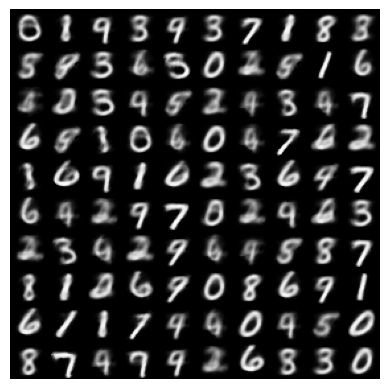

In [9]:
import matplotlib.pyplot as plt


n = 10

dim_latent = 2  # Dimension of the latent space

# Generate random samples from a standard normal distribution
z = torch.randn(n*n, dim_latent)

# z = torch.normal(0, 1., mu.shape) # sampling

generated = decoder(z)
imgs = np.zeros((n*28, n*28))

plt.figure()
for i in range(n*n):
    imgs[i//n  * 28: i//n * 28 + 28,i%n * 28 : i%n * 28 + 28] = 1 - generated[i].detach().numpy().reshape(28,28)
plt.axis('off')
plt.imshow(imgs, cmap='Greys')

## Latent space visualization

It is quite useful to visualize the latent space the variational auto-encoder. You can visualize it either for the training data or the dev data. Note that if you want to visualize a latent space when its dimension is greater than two (useful for the first part!), you could project it in 2 dimensions using PCA (its already implemented in scikit-learn!)

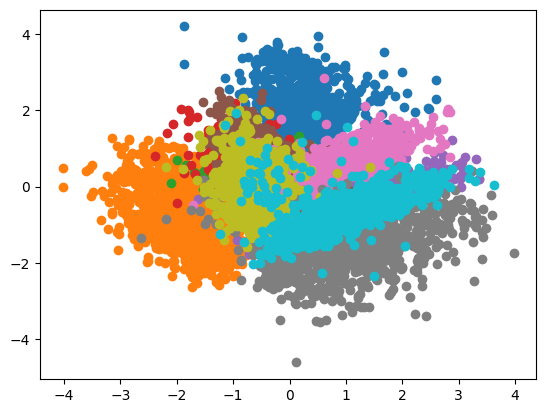

In [10]:
import matplotlib.cm as cm

labels = np.array(dev_data[1])
images = np.array(dev_data[0])
dl = DataLoader(list(zip(images, labels)), batch_size=128, shuffle=True, drop_last=True)
az = []
ay = []
with torch.no_grad():
    for x, y in dl:
        mu, log_sigma = encoder(x)

        z = torch.randn(mu.shape) * torch.exp(0.5 * log_sigma) + mu
        az += z.tolist()
        ay += y.tolist()
az = np.array(az)
ay = np.array(ay)

colors = cm.rainbow(np.linspace(0, 1, 10))
for i in range(10):
    plt.scatter(az[ay == i][:, 0], az[ay == i][:, 1])

<ipython-input-11-54440886c11c>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).view(-1, 784)  # Reshape and convert to tensor if not already


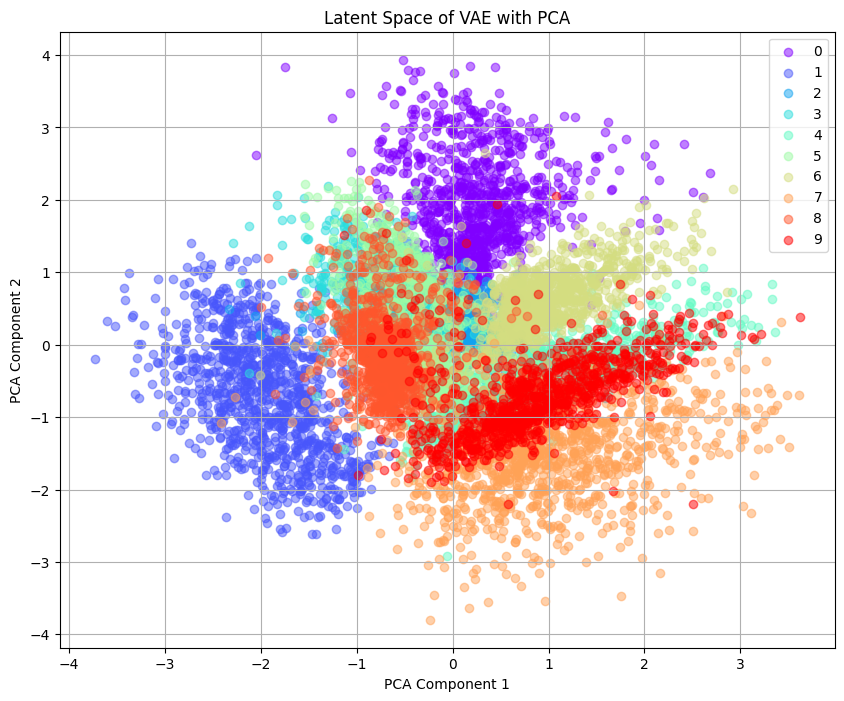

In [11]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA

# Load and prepare data
labels = np.array(dev_data[1])
images = np.array(dev_data[0]).astype(np.float32)  # Ensure data type
dl = DataLoader(list(zip(images, labels)), batch_size=128, shuffle=True, drop_last=True)

# Collect latent variables
az = []
ay = []
with torch.no_grad():
    for x, y in dl:
        x = torch.tensor(x).view(-1, 784)  # Reshape and convert to tensor if not already
        mu, log_sigma = encoder(x)
        z = torch.randn(mu.shape) * torch.exp(0.5 * log_sigma) + mu
        az.extend(z.numpy())  # Convert to numpy array and store
        ay.extend(y)

# Convert lists to arrays
az = np.array(az)
ay = np.array(ay)

# Applying PCA if needed
if az.shape[1] > 2:
    pca = PCA(n_components=2)
    az = pca.fit_transform(az)

# Visualize the latent space
colors = cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(az[ay == i][:, 0], az[ay == i][:, 1], color=colors[i], label=str(i), alpha=0.5)

plt.title('Latent Space of VAE with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


# GAN

Step 1: Define the GAN Architecture
We'll need to define two primary components for the GAN:

Generator: Takes a latent space vector (random noise) and generates images.
Discriminator: Tries to distinguish between real images from the dataset and fake images produced by the generator.
Here's the code for the GAN architecture:

In [12]:
import torch
from torch import nn

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, output_dim),
            nn.Tanh()  # Normalizing the output to [-1, 1]
        )

    def forward(self, z):
        return self.main(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output a probability
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.main(img_flat)
        return validity


Step 2: Training the GAN
Training a GAN involves alternating between updating the discriminator to better distinguish real images from fakes and updating the generator to fool the discriminator.

In [13]:
def train_gan(dl, generator, discriminator, lr=0.0002, b1=0.5, b2=0.999, epochs=50):
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
    adversarial_loss = torch.nn.BCELoss()

    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(dl):

            valid = torch.ones(imgs.size(0), 1, device=device, requires_grad=False)
            fake = torch.zeros(imgs.size(0), 1, device=device, requires_grad=False)

            real_imgs = imgs.to(device)

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()
            z = torch.randn(imgs.size(0), 100, device=device)
            gen_imgs = generator(z)
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)
            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

        print(f"Epoch {epoch + 1}/{epochs} | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

# Instantiate the GAN components
generator = Generator(input_dim=100, output_dim=784)
discriminator = Discriminator(input_dim=784)


Step 3: Visualize Generated Images
After training, you can generate images and visualize them similar to how we visualized the VAE's output:

In [14]:
z = torch.randn(10*10, 100)
generated_images = generator(z)



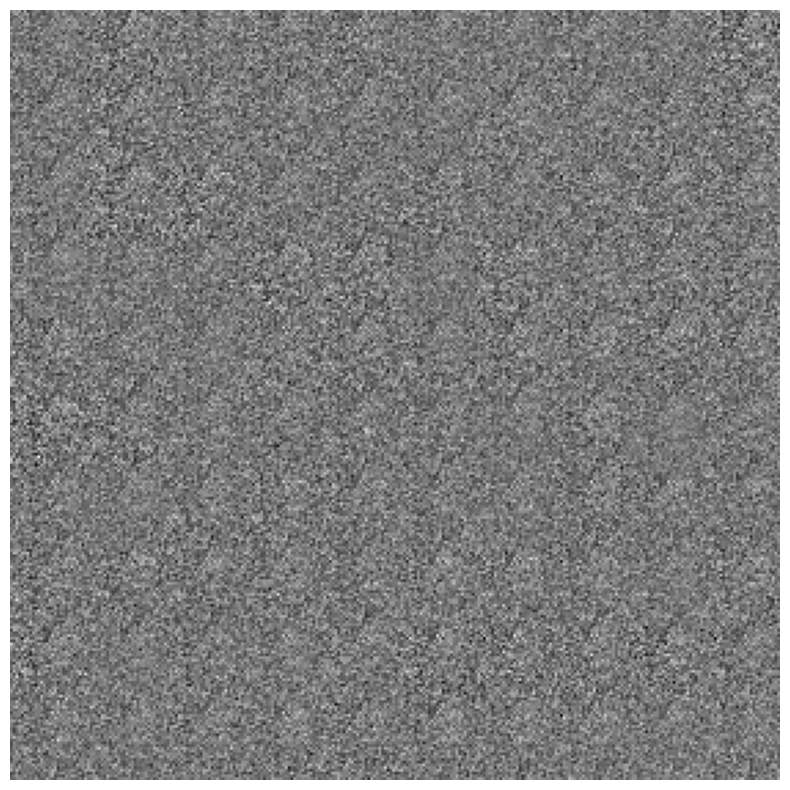

In [15]:
# Visualization code similar to the VAE section
# Assuming `generated_images` is a batch of images from the GAN
# Reshape and normalize the images
generated_images = generated_images.view(-1, 1, 28, 28)  # Reshape to (batch_size, channels, height, width)
generated_images = (generated_images + 1) / 2.0  # Normalize to [0, 1] since the Tanh function outputs in [-1, 1]

# Number of images along x and y axes
n = 10

# Create a large grid of images
grid = np.zeros((n * 28, n * 28))

for i in range(n*n):
    row = i // n * 28
    col = i % n * 28
    # Copy the image data to the appropriate location in the grid
    grid[row:row+28, col:col+28] = generated_images[i].squeeze().cpu().detach().numpy()

# Create a figure to display the results
plt.figure(figsize=(10, 10))
plt.imshow(grid, cmap='gray')  # Use a grayscale colormap
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


**The result is so bad**

Various strategies can be adopted to optimize the training process and network architecture of the model. Here are some common techniques and methods that can help improve the quality of MNIST images generated by GANs:

1. Adjust network architecture
Increase depth: Increasing the number of layers of the generator and discriminator can help the model learn more complex features.
Vary the width of the layers: Increasing the number of neurons in each layer provides more learning power.
Use Batch Normalization: This can help stabilize the training process, improve the convergence speed, and prevent the model from disappearing gradient problems in the early stages of training.
2. Adjust training parameters
Optimizer parameters: Try adjusting the learning rate (lr) and the beta parameters of the optimizer (b1, b2). Sometimes fine-tuning these parameters can significantly improve results.
Learning rate decay: Gradually reducing the learning rate as training progresses helps the model adjust weights more carefully in the later stages of training.
Use a different optimizer: While Adam is a good place to start, you can also try using other optimizers like RMSprop to see if there is an improvement.
3. Training skills
Label smoothing: Using random values from 0.7 to 1.2 for the true labels of the discriminator instead of a fixed 1.0 can increase the robustness of the generator.
Use a different loss function: Try using Wasserstein loss or LSGAN's loss instead of the traditional binary cross-entropy loss. These loss functions help improve training stability.
4. Use more complex models
DCGAN: For image generation tasks, Deep Convolutional Generative Adversarial Networks (DCGAN) are an efficient architecture that uses convolutional layers instead of fully connected layers, which generally yields better visual results.


In [16]:
import torch

# 检查CUDA是否可用，然后选择设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [17]:
# Example: Adding batch normalization and DCGAN architecture

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.init_size = output_dim // 4  # 初始层大小
        self.l1 = nn.Sequential(nn.Linear(input_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 1, 3, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

In [ ]:
# Instantiate the GAN components
generator = Generator(input_dim=100, output_dim=784)
discriminator = Discriminator(input_dim=784)




z = torch.randn(10*10, 100)
generated_images = generator(z)

# Visualization code similar to the VAE section
# Assuming `generated_images` is a batch of images from the GAN
# Reshape and normalize the images
generated_images = generated_images.view(-1, 1, 28, 28)  # Reshape to (batch_size, channels, height, width)
generated_images = (generated_images + 1) / 2.0  # Normalize to [0, 1] since the Tanh function outputs in [-1, 1]

# Number of images along x and y axes
n = 10

# Create a large grid of images
grid = np.zeros((n * 28, n * 28))

for i in range(n*n):
    row = i // n * 28
    col = i % n * 28
    # Copy the image data to the appropriate location in the grid
    grid[row:row+28, col:col+28] = generated_images[i].squeeze().cpu().detach().numpy()

# Create a figure to display the results
plt.figure(figsize=(10, 10))
plt.imshow(grid, cmap='gray')  # Use a grayscale colormap
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


**Always interrupted due to limited RAM**



By adjusting training parameters and using the ReLU activation function, it helps to speed up convergence and avoid the vanishing gradient problem, thereby improving the quality of the images generated by the model. These improvements help avoid the problem of generating total noise and allow the model to learn more useful feature representations

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.main(img_flat)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 11340301.49it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 340527.07it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 3143967.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 56526.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
generator = Generator(input_dim=100, output_dim=784).to(device)
discriminator = Discriminator(input_dim=784).to(device)
optimizer_G = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

num_epochs = 50

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        real_imgs = imgs.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), 100, device=device)
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Discriminator Loss: {d_loss.item()}, Generator Loss: {g_loss.item()}')


Epoch 1/50, Discriminator Loss: 0.37451666593551636, Generator Loss: 1.0854759216308594
Epoch 2/50, Discriminator Loss: 0.46374350786209106, Generator Loss: 1.5060030221939087
Epoch 3/50, Discriminator Loss: 0.3283897638320923, Generator Loss: 1.4648034572601318
Epoch 4/50, Discriminator Loss: 0.3015916347503662, Generator Loss: 1.4731369018554688
Epoch 5/50, Discriminator Loss: 0.17959171533584595, Generator Loss: 1.9230387210845947
Epoch 6/50, Discriminator Loss: 0.3806971311569214, Generator Loss: 1.1169462203979492
Epoch 7/50, Discriminator Loss: 0.3718183636665344, Generator Loss: 1.1401643753051758
Epoch 8/50, Discriminator Loss: 0.483000248670578, Generator Loss: 1.3647688627243042
Epoch 9/50, Discriminator Loss: 0.6117403507232666, Generator Loss: 1.1843775510787964
Epoch 10/50, Discriminator Loss: 0.6432350277900696, Generator Loss: 1.0294528007507324
Epoch 11/50, Discriminator Loss: 0.43373140692710876, Generator Loss: 1.2129011154174805
Epoch 12/50, Discriminator Loss: 0.329

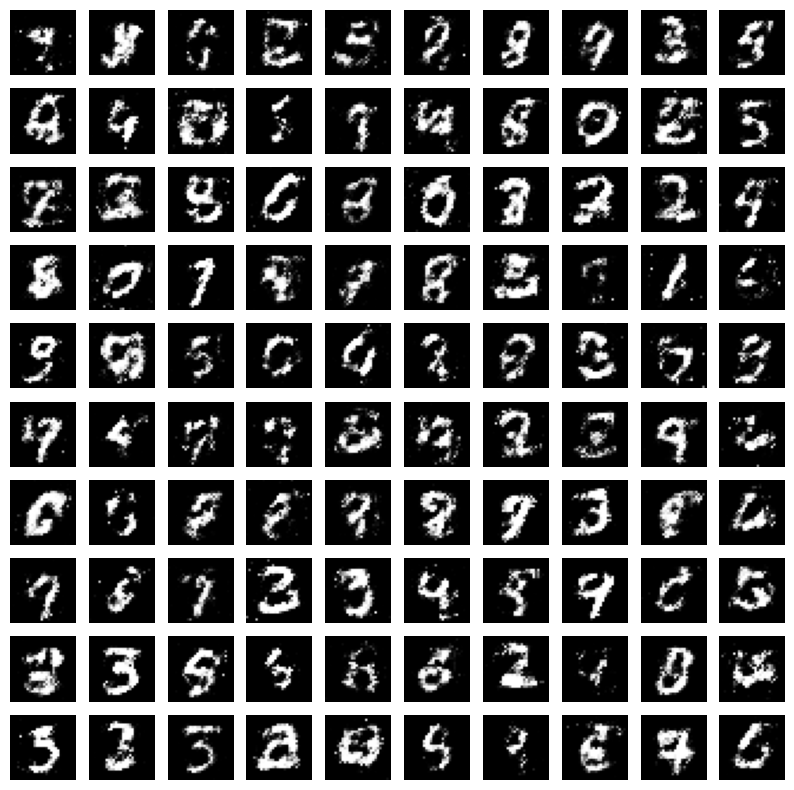

In [4]:
import matplotlib.pyplot as plt
import numpy as np

z = torch.randn(100, 100, device=device)
gen_imgs = generator(z).detach().cpu().view(-1, 1, 28, 28)
gen_imgs = (gen_imgs + 1) / 2.0  # Denormalize

fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        axs[i, j].imshow(gen_imgs[i * 10 + j].squeeze(0), cmap='gray')
        axs[i, j].axis('off')
plt.show()


**The generated pictures are good. But the losses of the discriminator and the generator do not seem to continue to decrease, but fluctuate, indicating that the dynamic balance between the discriminator and the generator has not reached the optimal state.**